##### CECS456 FinalProject Benjamin Gillmore
**Optimization of VGG**

#Importing the libraries

In [1]:
import os
#Needed because Tensorflow does not want to find my Cuda files from path
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.6/bin")
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#Verifiy that a GPU is found
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#Importing the dataset and split between training and validation data

In [3]:
data_dir = "./raw-img"
img_height = 256
img_width = 256
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12054 files belonging to 5 classes.
Using 9644 files for training.
Found 12054 files belonging to 5 classes.
Using 2410 files for validation.


#List the class names and verifiy data shapes

In [4]:
#Print all possible class names
class_names = train_ds.class_names
print(class_names)

#Print shapes of images and labels in first batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

#Print labels for first batch
print(labels_batch)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina']
(32, 256, 256, 3)
(32,)
tf.Tensor([3 0 0 1 1 0 1 1 1 1 0 0 1 4 1 1 4 0 1 3 1 0 1 2 1 0 2 4 1 0 3 1], shape=(32,), dtype=int32)


#Visualize first batch

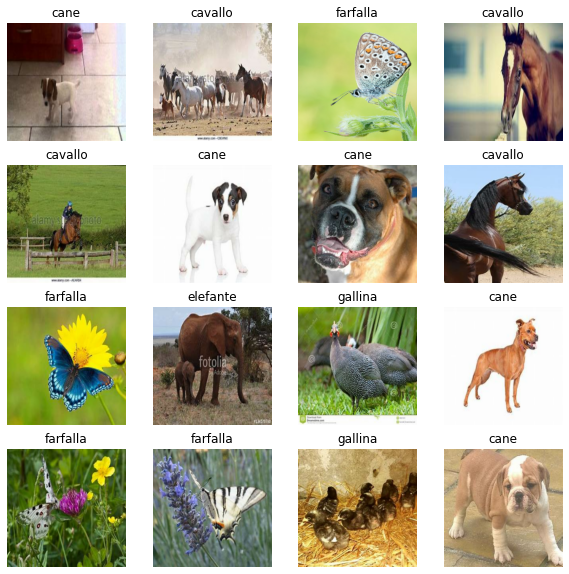

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Buffer images in memory to speed things up a bit

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(200).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Define different layer types

1.   InputLayer: Handles some rescaling so that pixel value is between 0 and 1
2.   HiddenLayer: Core of the CNN, VGG is n layers of convolusions followed by a pool @ given depth
3.   OutputLayer: Fully connected layer with dropout to avoid overfitting

In [7]:
def inputLayer(model):
    layerName = "input_layer"
    #augment data
    #model.add(keras.layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)))
    #model.add(keras.layers.RandomRotation(0.1))
    #model.add(keras.layers.RandomZoom(0.1))
    
    #rescale images so colors between 0-1
    model.add(keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

In [8]:
def hiddenLayer(model, inputSize, convLayers, depth, layerNum):
    layerName = "hidden_layer_" + str(layerNum) + "_"
    s1, s2 = inputSize
    model.add(keras.layers.Conv2D(filters=depth,kernel_size=(1,1),padding="same", activation="relu", name=layerName+"1x1_1"))
    for x in range(0,convLayers):
        model.add(keras.layers.Conv2D(filters=depth,kernel_size=(s1,s2),padding="same", activation="relu", name=layerName+str(x)))
    model.add(keras.layers.Conv2D(filters=64,kernel_size=(1,1),padding="same", activation="relu", name=layerName+"1x1_2"))
    model.add(keras.layers.MaxPooling2D(strides=(2,2)))
    

In [9]:
def bottleLayer(model, depth, outputLayers, layerNum):
    layerName = "bottle_layer_" + str(layerNum) + "_"
    model.add(keras.layers.Conv2D(filters=depth,kernel_size=(1,1),padding="same", activation="relu", name=layerName+"1x1_1"))
    model.add(keras.layers.Conv2D(filters=depth,kernel_size=(3,3),padding="same", activation="relu", name=layerName+"_3x3"))
    model.add(keras.layers.Conv2D(filters=64,kernel_size=(1,1),padding="same", activation="relu", name=layerName+"1x1_2"))
    

In [10]:
def outputLayer(model, denseLayers, num_classes, dropRate):
    layerName = "output_layer_"
    #model.add(keras.layers.Dropout(rate=dropRate, name=layerName+"dropout"))
    model.add(keras.layers.Flatten(name=layerName+"flatten"))
    for x in range(0,denseLayers):
        model.add(keras.layers.Dense(1024, activation='relu', name=layerName+"dense_"+str(x)))
        #model.add(keras.layers.Dropout(rate=dropRate, name=layerName+"dropout_"+str(x)))
    model.add(keras.layers.Dense(num_classes,activation='softmax', name=layerName+"final_dense"))


#Build the actual model by using the above function; print the summary

In [11]:
num_classes = len(class_names)
model = keras.Sequential()
inputLayer(model)
hiddenLayer(model, (3,3), 2, 64, 1)
hiddenLayer(model, (3,3), 2, 128, 2)
#bottleLayer(model, 128, 64, 7)
hiddenLayer(model, (3,3), 3, 256, 3)
#bottleLayer(model, 256, 64, 8)
hiddenLayer(model, (3,3), 3, 512, 4)
hiddenLayer(model, (3,3), 3, 512, 5)
#bottleLayer(model, 512, 64, 6)
outputLayer(model, 2, num_classes, 0) #0
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 hidden_layer_1_1x1_1 (Conv2  (None, 256, 256, 64)     256       
 D)                                                              
                                                                 
 hidden_layer_1_0 (Conv2D)   (None, 256, 256, 64)      36928     
                                                                 
 hidden_layer_1_1 (Conv2D)   (None, 256, 256, 64)      36928     
                                                                 
 hidden_layer_1_1x1_2 (Conv2  (None, 256, 256, 64)     4160      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0

#Set the learning rate schedule and compile the model
1.   lr = lr * 0.9 every 10,000 steps
2.   specify the optimizer: Stochastic Gradiant Decent

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2, #1e-3 1e-4
    decay_steps=10000,
    decay_rate=0.9)

#optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6) #-6
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.compile(optimizer=optimizer, metrics=['accuracy'])

# Train convolusional neural network model


1.   batch size is 32 (defined in data import)
2.   specify the epochs as 20
3.   include a validation set


In [13]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
302/302 [==============================] - 72s 223ms/step - loss: 1.5536 - accuracy: 0.4033 - val_loss: 1.4643 - val_accuracy: 0.4037
Epoch 2/100
302/302 [==============================] - 65s 217ms/step - loss: 1.4600 - accuracy: 0.4034 - val_loss: 1.4576 - val_accuracy: 0.4037
Epoch 3/100
302/302 [==============================] - 65s 217ms/step - loss: 1.4550 - accuracy: 0.4034 - val_loss: 1.4523 - val_accuracy: 0.4037
Epoch 4/100
302/302 [==============================] - 65s 217ms/step - loss: 1.4506 - accuracy: 0.4034 - val_loss: 1.4461 - val_accuracy: 0.4037
Epoch 5/100
302/302 [==============================] - 65s 217ms/step - loss: 1.4445 - accuracy: 0.4035 - val_loss: 1.4373 - val_accuracy: 0.4037
Epoch 6/100
302/302 [==============================] - 65s 216ms/step - loss: 1.4342 - accuracy: 0.4088 - val_loss: 1.4254 - val_accuracy: 0.4133
Epoch 7/100
302/302 [==============================] - 65s 217ms/step - loss: 1.4183 - accuracy: 0.4294 - val_loss: 1.3996 -

Epoch 57/100
302/302 [==============================] - 65s 217ms/step - loss: 0.8200 - accuracy: 0.6959 - val_loss: 0.9001 - val_accuracy: 0.6676
Epoch 58/100
302/302 [==============================] - 65s 217ms/step - loss: 0.8118 - accuracy: 0.6975 - val_loss: 0.8961 - val_accuracy: 0.6643
Epoch 59/100
302/302 [==============================] - 65s 217ms/step - loss: 0.8084 - accuracy: 0.7003 - val_loss: 0.9072 - val_accuracy: 0.6548
Epoch 60/100
302/302 [==============================] - 65s 217ms/step - loss: 0.8027 - accuracy: 0.7016 - val_loss: 0.8956 - val_accuracy: 0.6722
Epoch 61/100
302/302 [==============================] - 65s 217ms/step - loss: 0.7993 - accuracy: 0.6979 - val_loss: 0.9103 - val_accuracy: 0.6664
Epoch 62/100
302/302 [==============================] - 65s 217ms/step - loss: 0.7922 - accuracy: 0.7041 - val_loss: 0.8886 - val_accuracy: 0.6726
Epoch 63/100
302/302 [==============================] - 65s 217ms/step - loss: 0.7892 - accuracy: 0.7073 - val_loss: 0

#Evaluation

1.   print the total loss on testing set
2.   print the accuracy of testing set

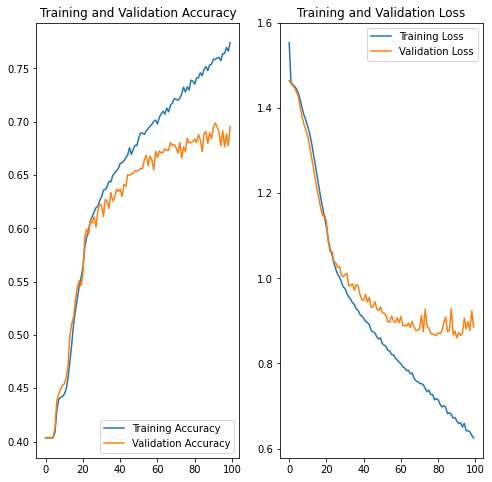

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()